Step 1: Install PySpark in Colab

In [ ]:
!pip install pyspark

 Step 2: Sample Apache Log File

In [ ]:
!wget https://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs -O access.log

--2025-05-21 08:32:34--  https://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2370789 (2.3M) [text/plain]
Saving to: ‘access.log’

access.log          100%[===================>]   2.26M  --.-KB/s    in 0.06s   

2025-05-21 08:32:34 (41.1 MB/s) - ‘access.log’ saved [2370789/2370789]



Step 3: Start PySpark Session and Load Logs

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Log Analyzer").getOrCreate()

log_df = spark.read.text("access.log")
log_df.show(20, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Step 4: Parse Log Data using Regex

In [ ]:
from pyspark.sql.functions import regexp_extract

log_pattern = r'(^\S+) - - \[(.*?)\] "(.*?)" (\d{3}) (\d+)'

parsed_logs = log_df.select(
    regexp_extract('value', log_pattern, 1).alias('ip'),
    regexp_extract('value', log_pattern, 2).alias('timestamp'),
    regexp_extract('value', log_pattern, 3).alias('request'),
    regexp_extract('value', log_pattern, 4).alias('status'),
    regexp_extract('value', log_pattern, 5).alias('bytes')
)

parsed_logs.show(10)

+------------+--------------------+--------------------+------+------+
|          ip|           timestamp|             request|status| bytes|
+------------+--------------------+--------------------+------+------+
|83.149.9.216|17/May/2015:10:05...|GET /presentation...|   200|203023|
|83.149.9.216|17/May/2015:10:05...|GET /presentation...|   200|171717|
|83.149.9.216|17/May/2015:10:05...|GET /presentation...|   200| 26185|
|83.149.9.216|17/May/2015:10:05...|GET /presentation...|   200|  7697|
|83.149.9.216|17/May/2015:10:05...|GET /presentation...|   200|  2892|
|83.149.9.216|17/May/2015:10:05...|GET /presentation...|   200|430406|
|83.149.9.216|17/May/2015:10:05...|GET /presentation...|   200| 38720|
|83.149.9.216|17/May/2015:10:05...|GET /presentation...|   200| 41820|
|83.149.9.216|17/May/2015:10:05...|GET /presentation...|   200| 52878|
|83.149.9.216|17/May/2015:10:05...|GET /presentation...|   200|321631|
+------------+--------------------+--------------------+------+------+
only s

Step 5: Analysis

In [ ]:
parsed_logs.groupBy("ip").count().orderBy("count", ascending=False).show(15)

+---------------+-----+
|             ip|count|
+---------------+-----+
|               |  669|
|  66.249.73.135|  432|
|   46.105.14.53|  364|
| 130.237.218.86|  293|
|    50.16.19.13|  113|
| 209.85.238.199|  102|
|     75.97.9.59|   99|
| 68.180.224.225|   95|
| 198.46.149.143|   82|
| 208.115.111.72|   73|
| 208.115.113.88|   66|
|108.171.116.194|   65|
|  208.91.156.11|   60|
|   65.55.213.73|   59|
|  100.43.83.137|   53|
+---------------+-----+
only showing top 15 rows



Most Frequent URLs:

In [ ]:
from pyspark.sql.functions import split

parsed_logs = parsed_logs.withColumn("url", split("request", " ").getItem(1))
parsed_logs.groupBy("url").count().orderBy("count", ascending=False).show(13)

+--------------------+-----+
|                 url|count|
+--------------------+-----+
|        /favicon.ico|  788|
|                NULL|  669|
|         /style2.css|  532|
|          /reset.css|  528|
|/images/jordan-80...|  522|
|/images/web/2009/...|  506|
|/blog/tags/puppet...|  488|
|  /projects/xdotool/|  221|
|        /?flav=rss20|  217|
|                   /|  194|
|/projects/xdotool...|  147|
|         /?flav=atom|  137|
|/articles/dynamic...|  135|
+--------------------+-----+
only showing top 13 rows



Status Code Distribution:

In [ ]:
parsed_logs.groupBy("status").count().orderBy("count", ascending=False).show()

+------+-----+
|status|count|
+------+-----+
|   200| 8913|
|      |  669|
|   404|  205|
|   301|  163|
|   206|   45|
|   403|    2|
|   416|    2|
|   500|    1|
+------+-----+



Error Logs (4xx or 5xx):

In [ ]:
error_logs = parsed_logs.filter(parsed_logs.status.startswith("4") | parsed_logs.status.startswith("5"))
error_logs.groupBy("status").count().show()

+------+-----+
|status|count|
+------+-----+
|   404|  205|
|   403|    2|
|   416|    2|
|   500|    1|
+------+-----+



Step 6: Visualize in Colab

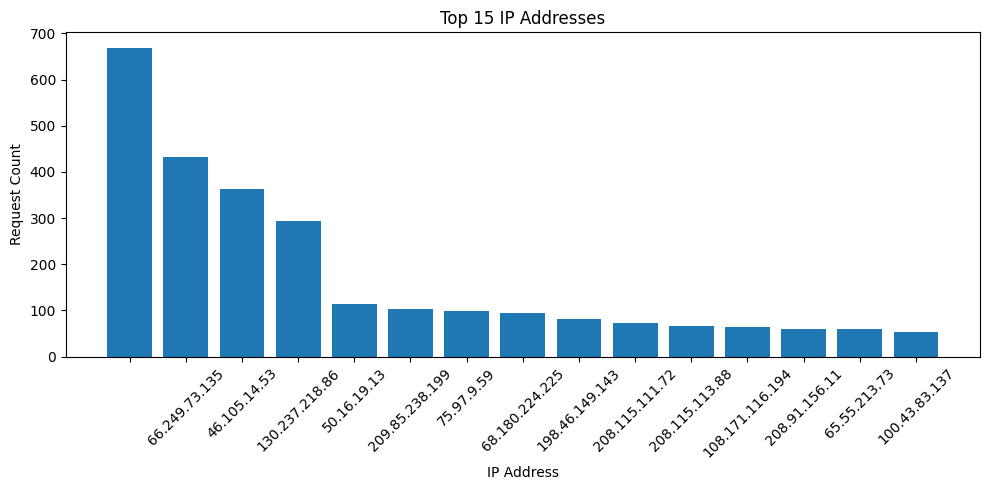

In [ ]:
top_ips = parsed_logs.groupBy("ip").count().orderBy("count", ascending=False).limit(15).toPandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(top_ips['ip'], top_ips['count'])
plt.xticks(rotation=45)
plt.title("Top 15 IP Addresses")
plt.xlabel("IP Address")
plt.ylabel("Request Count")
plt.tight_layout()
plt.show()